In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from scipy.stats import pearsonr
import seaborn as sns

import sys

# Add the features directory to path - navigate from models/code to features
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'features'))
from trend_indicator_pipeline_pkg import TrendIndicatorPipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline, CorrelationIndicatorPipeline, FractalDimensionPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

from sklearn.model_selection import train_test_split
from pycaret.classification import setup, compare_models, save_model, predict_model, pull, tune_model, finalize_model, load_model

In [3]:
# Load trained models from models/model directory
model_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'models', 'model')
print(f"Loading models from: {model_dir}")

# Model names to load (PyCaret format)
model_names = ['RandomForestClassifier', 'ExtraTreesClassifier', 'DecisionTreeClassifier', 
               'KNeighborsClassifier', 'LGBMClassifier']

# Load models using PyCaret format
trained_models = {}
for model_name in model_names:
    model_path = os.path.join(model_dir, f'btc_trading_{model_name}_pycaret')
    try:
        loaded_model = load_model(model_path)
        trained_models[model_name] = loaded_model
        print(f"✓ Loaded {model_name}")
    except Exception as e:
        print(f"✗ Error loading {model_name}: {e}")

print(f"\nSuccessfully loaded {len(trained_models)} models")

Loading models from: e:\Coding\Crypto_Research\models\model
Transformation Pipeline and Model Successfully Loaded
✓ Loaded RandomForestClassifier
Transformation Pipeline and Model Successfully Loaded
✓ Loaded ExtraTreesClassifier
Transformation Pipeline and Model Successfully Loaded
✓ Loaded DecisionTreeClassifier
Transformation Pipeline and Model Successfully Loaded
✓ Loaded KNeighborsClassifier
Transformation Pipeline and Model Successfully Loaded
✓ Loaded LGBMClassifier

Successfully loaded 5 models


In [4]:
# Load dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'BTCUSD_2023-1min_ML.csv')
print(f"Loading dataset from: {data_path}")

df = pd.read_csv(data_path)
df = df.dropna()
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Target distribution:\n{df['future_trend'].value_counts()}")

Loading dataset from: e:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML.csv
Dataset shape: (427042, 26)
Columns: ['Unnamed: 0.1', 'Timestamp', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
Target distribution:
future_trend
0    317970
1    109072
Name: count, dtype: int64


In [5]:
# Generate prediction probabilities for each model
# First, set up the same data preprocessing as in original training
clf_setup = setup(
    data=df,
    target='future_trend',
    session_id=42,
    train_size=0.7,
    fold_shuffle=True,
    fold=12,
    verbose=False,
    ignore_features=['Unnamed: 0.1', 'Timestamp', 'Unnamed: 0', 'future_close', 'future_return']
)

print("PyCaret setup completed for prediction probability generation")

PyCaret setup completed for prediction probability generation


In [6]:
# Generate probabilities for each model using Option 3 approach
prediction_results = {}

for model_name, model in trained_models.items():
    print(f"\nGenerating probabilities for {model_name}...")
    
    # Get predictions with probabilities using predict_model
    pred_df = predict_model(model, data=df.copy())
    
    # Extract prediction probability (Score column should be added by PyCaret)
    if 'Score' in pred_df.columns:
        probabilities = pred_df['Score'].values
    else:
        # Fallback: use direct predict_proba on the underlying sklearn model
        from pycaret.classification import get_config
        X = get_config('X')
        probabilities = model.predict_proba(X)[:, 1]
    
    # Store results
    prediction_results[model_name] = {
        'probabilities': probabilities,
        'predictions': pred_df['prediction_label'].values,
        'actual_labels': df['future_trend'].values,
        'actual_returns': df['future_return'].values
    }
    
    print(f"✓ Generated {len(probabilities)} probability predictions")
    print(f"  Probability range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    print(f"  Mean probability: {probabilities.mean():.3f}")

print(f"\n✅ Probability generation completed for all {len(prediction_results)} models")


Generating probabilities for RandomForestClassifier...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9993,1.0000,0.9985,0.9989,0.9987,0.9983,0.9983


✓ Generated 427042 probability predictions
  Probability range: [0.000, 1.000]
  Mean probability: 0.255

Generating probabilities for ExtraTreesClassifier...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9993,1.0000,0.9985,0.9988,0.9986,0.9982,0.9982


✓ Generated 427042 probability predictions
  Probability range: [0.000, 1.000]
  Mean probability: 0.255

Generating probabilities for DecisionTreeClassifier...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9990,0.9986,0.9979,0.9982,0.9980,0.9974,0.9974


✓ Generated 427042 probability predictions
  Probability range: [0.000, 1.000]
  Mean probability: 0.255

Generating probabilities for KNeighborsClassifier...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9959,0.9996,0.9917,0.9923,0.9920,0.9893,0.9893


✓ Generated 427042 probability predictions
  Probability range: [0.000, 1.000]
  Mean probability: 0.255

Generating probabilities for LGBMClassifier...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9930,0.9996,0.9851,0.9873,0.9862,0.9815,0.9815


✓ Generated 427042 probability predictions
  Probability range: [0.000, 1.000]
  Mean probability: 0.256

✅ Probability generation completed for all 5 models


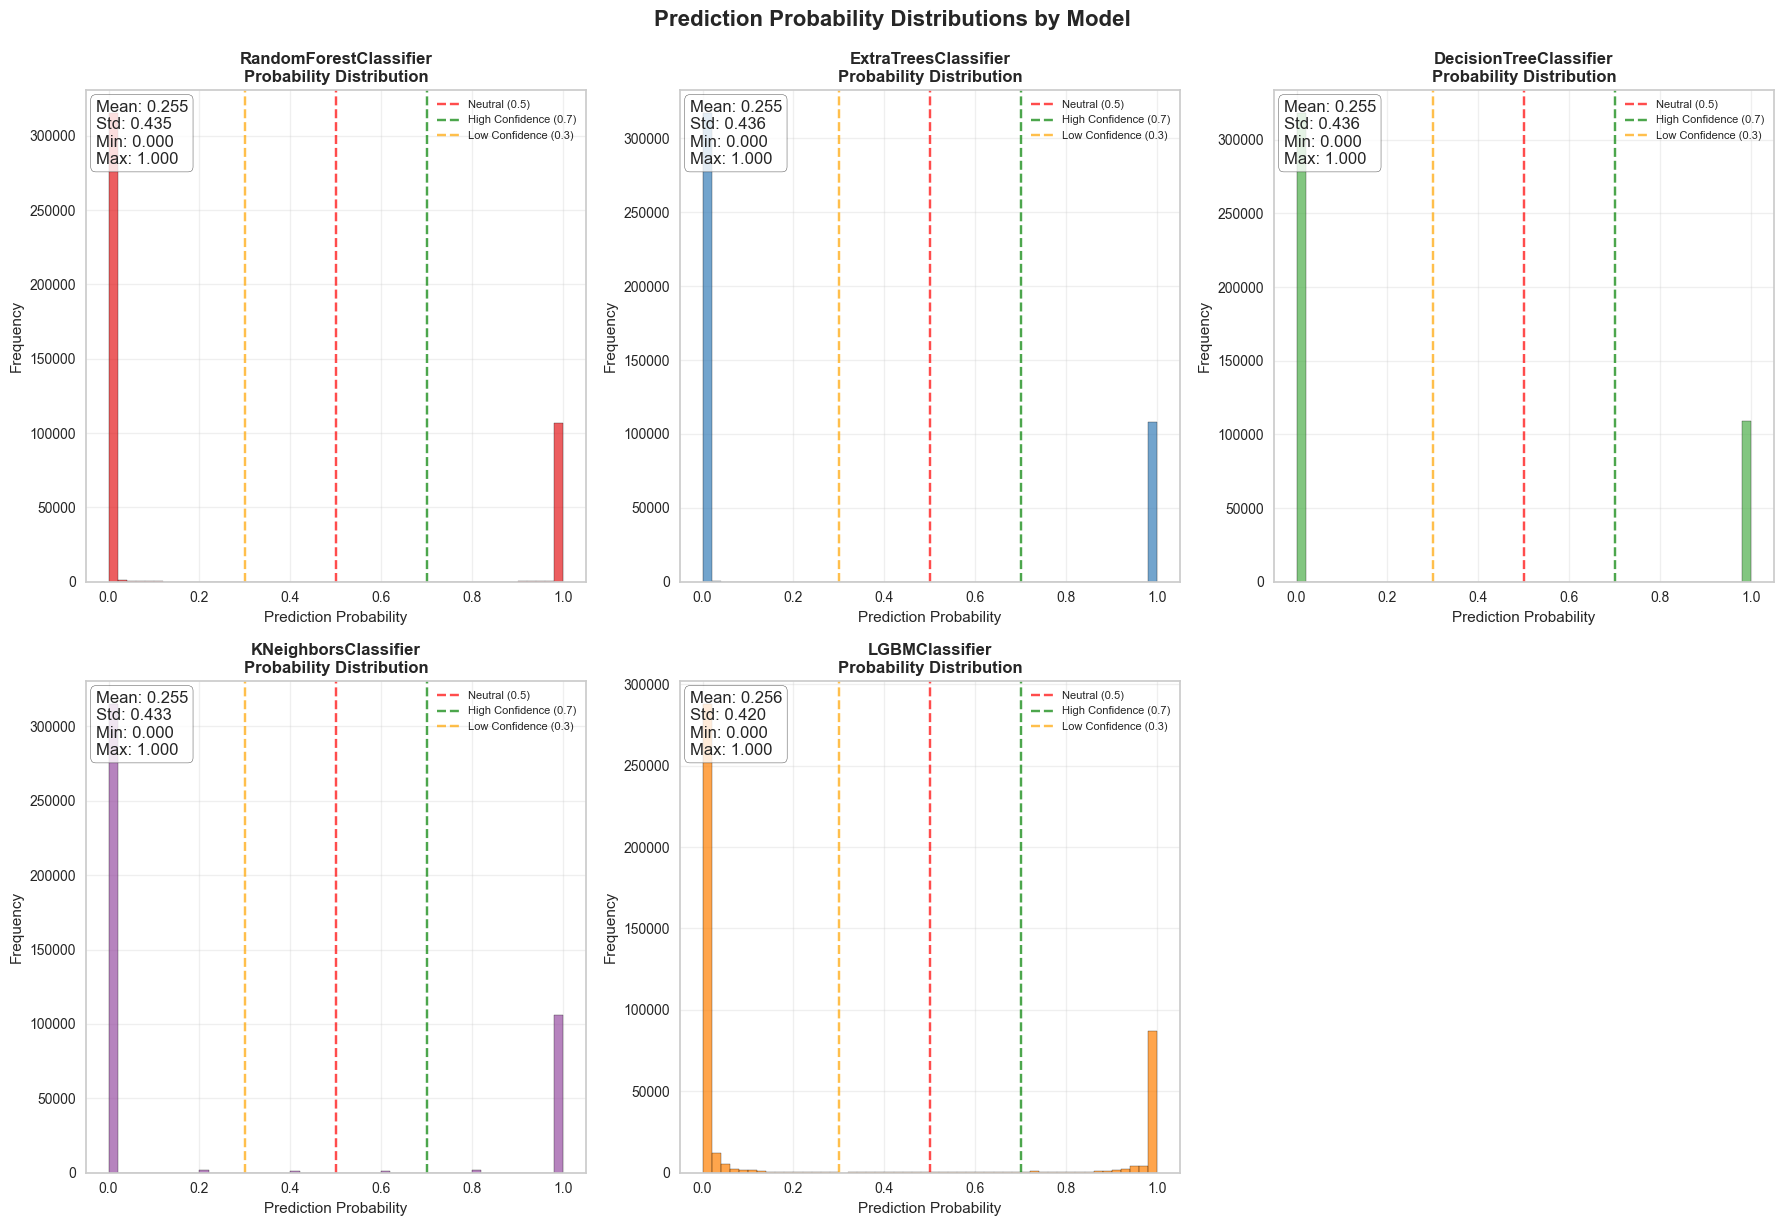

In [7]:
# Plot probability histograms for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model_name, results) in enumerate(prediction_results.items()):
    probabilities = results['probabilities']
    
    # Plot histogram
    axes[i].hist(probabilities, bins=50, alpha=0.7, color=plt.cm.Set1(i), edgecolor='black')
    axes[i].set_title(f'{model_name}\nProbability Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prediction Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics as text
    stats_text = f'Mean: {probabilities.mean():.3f}\nStd: {probabilities.std():.3f}\nMin: {probabilities.min():.3f}\nMax: {probabilities.max():.3f}'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add threshold lines
    axes[i].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Neutral (0.5)')
    axes[i].axvline(x=0.7, color='green', linestyle='--', alpha=0.7, label='High Confidence (0.7)')
    axes[i].axvline(x=0.3, color='orange', linestyle='--', alpha=0.7, label='Low Confidence (0.3)')
    axes[i].legend(fontsize=8)

# Remove empty subplot
if len(prediction_results) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Prediction Probability Distributions by Model', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [8]:
# Create confidence bins and analyze actual performance per bin
def analyze_confidence_bins(probabilities, actual_returns, actual_labels, model_name, n_bins=10):
    """Analyze performance across different confidence bins"""
    
    # Create confidence bins
    bins = np.linspace(0, 1, n_bins + 1)
    bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(n_bins)]
    
    # Assign each prediction to a bin
    bin_indices = np.digitize(probabilities, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Handle edge cases
    
    # Analyze performance per bin
    bin_analysis = []
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:  # Only analyze bins with data
            bin_probs = probabilities[mask]
            bin_returns = actual_returns[mask]
            bin_labels_actual = actual_labels[mask]
            
            analysis = {
                'bin_range': bin_labels[i],
                'bin_center': (bins[i] + bins[i+1]) / 2,
                'count': mask.sum(),
                'avg_probability': bin_probs.mean(),
                'avg_actual_return': bin_returns.mean(),
                'std_actual_return': bin_returns.std(),
                'positive_return_rate': (bin_returns > 0).mean(),
                'accuracy': (bin_labels_actual == (bin_probs > 0.5).astype(int)).mean(),
                'avg_abs_return': np.abs(bin_returns).mean()
            }
            bin_analysis.append(analysis)
    
    return pd.DataFrame(bin_analysis)

# Analyze all models
bin_analysis_results = {}
for model_name, results in prediction_results.items():
    print(f"\n=== Confidence Bin Analysis: {model_name} ===")
    
    analysis_df = analyze_confidence_bins(
        results['probabilities'], 
        results['actual_returns'], 
        results['actual_labels'],
        model_name
    )
    
    bin_analysis_results[model_name] = analysis_df
    print(analysis_df.round(4))


=== Confidence Bin Analysis: RandomForestClassifier ===
  bin_range  bin_center   count  avg_probability  avg_actual_return  \
0   0.0-0.1        0.05  316812           0.0003             0.0129   
1   0.1-0.2        0.15     565           0.1384             0.0158   
2   0.2-0.3        0.25     333           0.2464             0.0118   
3   0.3-0.4        0.35     174           0.3436             0.0140   
4   0.4-0.5        0.45     116           0.4403             0.0213   
5   0.5-0.6        0.55     112           0.5470             0.0276   
6   0.6-0.7        0.65     218           0.6600             0.0184   
7   0.7-0.8        0.75     280           0.7520             0.0117   
8   0.8-0.9        0.85     485           0.8532             0.0141   
9   0.9-1.0        0.95  107947           0.9991             0.0131   

   std_actual_return  positive_return_rate  accuracy  avg_abs_return  
0             0.0584                0.5267    0.7448          0.0400  
1             0.061

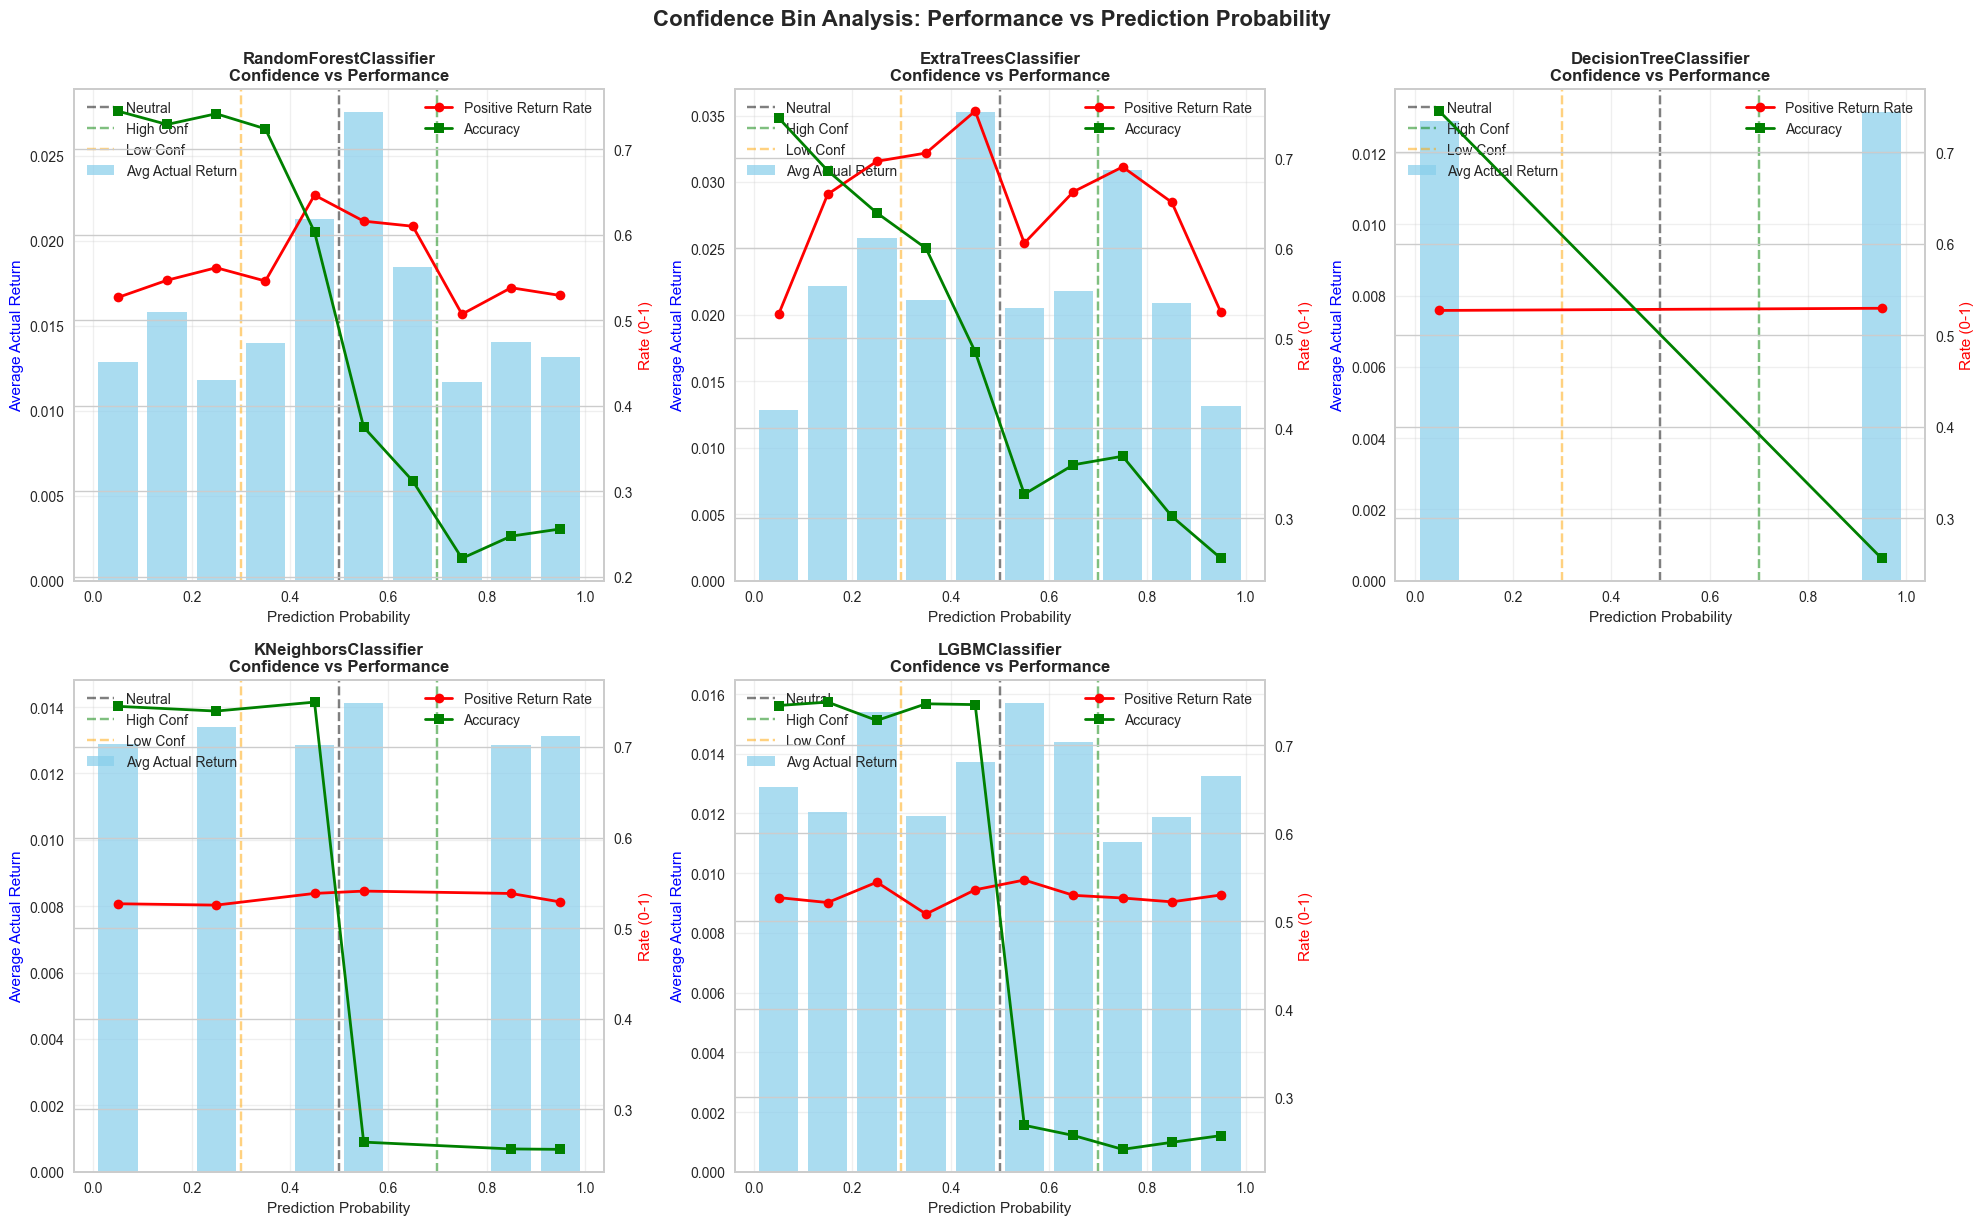

In [9]:
# Visualize confidence bin analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (model_name, analysis_df) in enumerate(bin_analysis_results.items()):
    if not analysis_df.empty:
        ax = axes[i]
        
        # Create twin axes for different scales
        ax2 = ax.twinx()
        
        # Plot average actual return per confidence bin
        bars1 = ax.bar(analysis_df['bin_center'], analysis_df['avg_actual_return'], 
                      alpha=0.7, color='skyblue', label='Avg Actual Return', width=0.08)
        
        # Plot positive return rate
        line1 = ax2.plot(analysis_df['bin_center'], analysis_df['positive_return_rate'], 
                        color='red', marker='o', linewidth=2, label='Positive Return Rate')
        
        # Plot accuracy
        line2 = ax2.plot(analysis_df['bin_center'], analysis_df['accuracy'], 
                        color='green', marker='s', linewidth=2, label='Accuracy')
        
        # Formatting
        ax.set_title(f'{model_name}\nConfidence vs Performance', fontsize=12, fontweight='bold')
        ax.set_xlabel('Prediction Probability')
        ax.set_ylabel('Average Actual Return', color='blue')
        ax2.set_ylabel('Rate (0-1)', color='red')
        ax.grid(True, alpha=0.3)
        
        # Add threshold lines
        ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Neutral')
        ax.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='High Conf')
        ax.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Low Conf')
        
        # Legends
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

# Remove empty subplot
if len(bin_analysis_results) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Confidence Bin Analysis: Performance vs Prediction Probability', fontsize=16, fontweight='bold', y=1.02)
plt.show()

=== Correlation Analysis: Prediction Probabilities vs Actual Returns ===
Model                   | Correlation | P-value    | Sample Size
-----------------------------------------------------------------
RandomForestClassifier |    0.002007 |   0.189615 |     427,042
ExtraTreesClassifier |    0.002017 |   0.187527 |     427,042
DecisionTreeClassifier |    0.001926 |   0.208187 |     427,042
KNeighborsClassifier |    0.001883 |   0.218441 |     427,042
LGBMClassifier       |    0.002348 |   0.124870 |     427,042

Correlation Summary:
Mean correlation: 0.002036
Std correlation:  0.000164
Min correlation:  0.001883
Max correlation:  0.002348


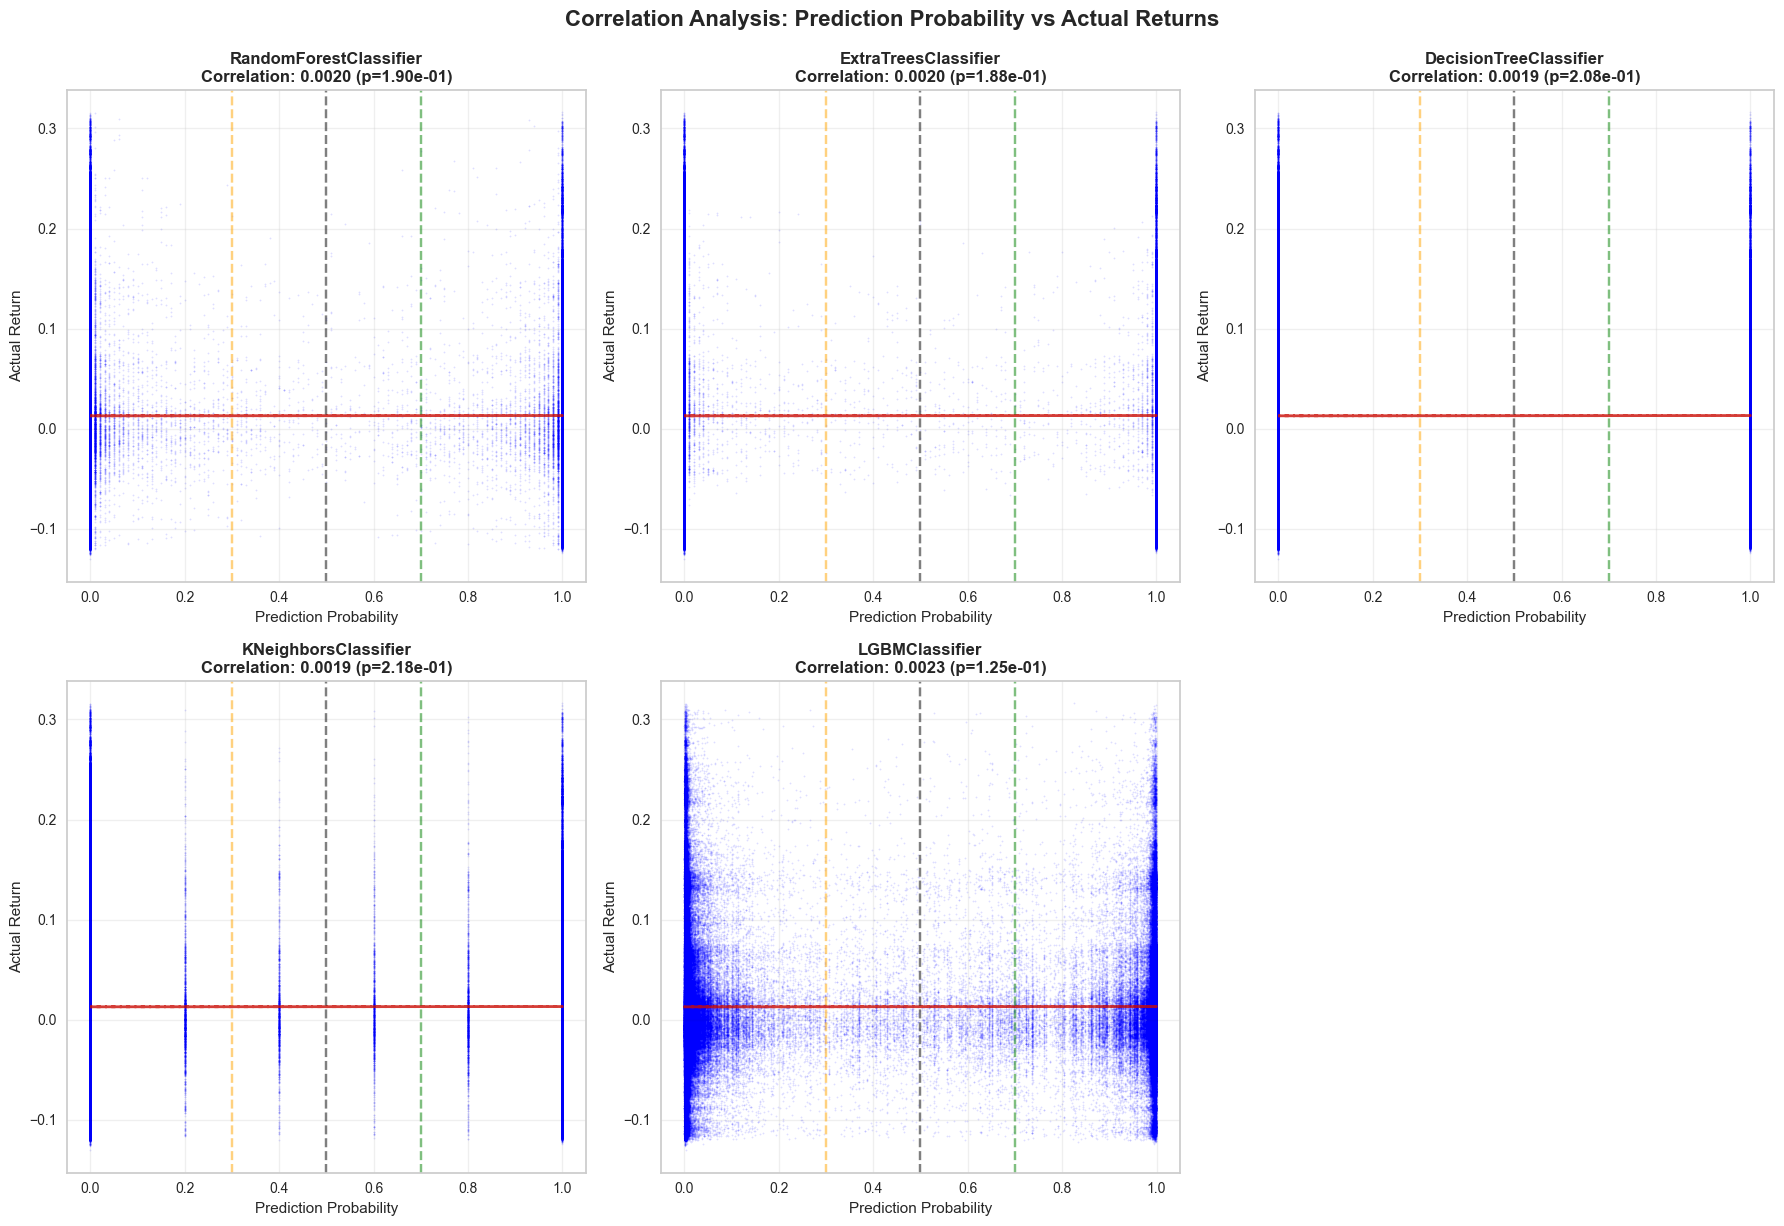

In [10]:
# Calculate correlation between probabilities and actual returns
correlation_results = {}

print("=== Correlation Analysis: Prediction Probabilities vs Actual Returns ===")
print("Model                   | Correlation | P-value    | Sample Size")
print("-" * 65)

for model_name, results in prediction_results.items():
    probabilities = results['probabilities']
    actual_returns = results['actual_returns']
    
    # Calculate Pearson correlation
    correlation, p_value = pearsonr(probabilities, actual_returns)
    
    correlation_results[model_name] = {
        'correlation': correlation,
        'p_value': p_value,
        'sample_size': len(probabilities),
        'significant': p_value < 0.05
    }
    
    print(f"{model_name:20} | {correlation:11.6f} | {p_value:10.6f} | {len(probabilities):11,}")

# Summary statistics
correlations = [results['correlation'] for results in correlation_results.values()]
print(f"\nCorrelation Summary:")
print(f"Mean correlation: {np.mean(correlations):.6f}")
print(f"Std correlation:  {np.std(correlations):.6f}")
print(f"Min correlation:  {np.min(correlations):.6f}")
print(f"Max correlation:  {np.max(correlations):.6f}")

# Visualize correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model_name, results) in enumerate(prediction_results.items()):
    probabilities = results['probabilities']
    actual_returns = results['actual_returns']
    correlation = correlation_results[model_name]['correlation']
    p_value = correlation_results[model_name]['p_value']
    
    # Create scatter plot with regression line
    axes[i].scatter(probabilities, actual_returns, alpha=0.1, s=1, color='blue')
    
    # Add regression line
    z = np.polyfit(probabilities, actual_returns, 1)
    p = np.poly1d(z)
    axes[i].plot(probabilities, p(probabilities), "r--", alpha=0.8, linewidth=2)
    
    axes[i].set_title(f'{model_name}\nCorrelation: {correlation:.4f} (p={p_value:.2e})', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prediction Probability')
    axes[i].set_ylabel('Actual Return')
    axes[i].grid(True, alpha=0.3)
    
    # Add threshold lines
    axes[i].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Neutral')
    axes[i].axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='High Conf')
    axes[i].axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Low Conf')

# Remove empty subplot
if len(prediction_results) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Correlation Analysis: Prediction Probability vs Actual Returns', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [11]:
# Determine optimal thresholds based on risk/return trade-offs
def optimize_thresholds(probabilities, actual_returns, threshold_ranges=None):
    """Find optimal buy/sell thresholds based on risk-return trade-off"""
    
    if threshold_ranges is None:
        # Test different threshold combinations
        threshold_ranges = {
            'buy_thresholds': np.arange(0.5, 0.95, 0.05),   # High confidence for buying
            'sell_thresholds': np.arange(0.05, 0.5, 0.05)   # Low confidence for selling
        }
    
    results = []
    
    for buy_threshold in threshold_ranges['buy_thresholds']:
        for sell_threshold in threshold_ranges['sell_thresholds']:
            
            # Apply thresholds
            buy_signals = probabilities >= buy_threshold
            sell_signals = probabilities <= sell_threshold
            actionable_signals = buy_signals | sell_signals
            
            if actionable_signals.sum() > 0:  # Only analyze if we have signals
                
                # Calculate metrics for actionable signals
                actionable_returns = actual_returns[actionable_signals]
                actionable_probs = probabilities[actionable_signals]
                buy_returns = actual_returns[buy_signals]
                sell_returns = actual_returns[sell_signals]  # These should be negative ideally
                
                metrics = {
                    'buy_threshold': buy_threshold,
                    'sell_threshold': sell_threshold,
                    'total_signals': actionable_signals.sum(),
                    'buy_signals': buy_signals.sum(),
                    'sell_signals': sell_signals.sum(),
                    'signal_rate': actionable_signals.mean(),
                    'avg_return': actionable_returns.mean(),
                    'avg_buy_return': buy_returns.mean() if len(buy_returns) > 0 else 0,
                    'avg_sell_return': sell_returns.mean() if len(sell_returns) > 0 else 0,
                    'return_std': actionable_returns.std(),
                    'positive_rate': (actionable_returns > 0).mean(),
                    'sharpe_ratio': actionable_returns.mean() / actionable_returns.std() if actionable_returns.std() > 0 else 0,
                    'max_return': actionable_returns.max(),
                    'min_return': actionable_returns.min()
                }
                
                results.append(metrics)
    
    return pd.DataFrame(results)

# Optimize thresholds for each model
threshold_optimization_results = {}

for model_name, results in prediction_results.items():
    print(f"\n=== Threshold Optimization: {model_name} ===")
    
    optimization_df = optimize_thresholds(
        results['probabilities'], 
        results['actual_returns']
    )
    
    if not optimization_df.empty:
        threshold_optimization_results[model_name] = optimization_df
        
        # Find best thresholds based on different criteria
        best_sharpe = optimization_df.loc[optimization_df['sharpe_ratio'].idxmax()]
        best_return = optimization_df.loc[optimization_df['avg_return'].idxmax()]
        best_positive_rate = optimization_df.loc[optimization_df['positive_rate'].idxmax()]
        
        print(f"Best Sharpe Ratio: Buy≥{best_sharpe['buy_threshold']:.2f}, Sell≤{best_sharpe['sell_threshold']:.2f}")
        print(f"  Sharpe: {best_sharpe['sharpe_ratio']:.3f}, Avg Return: {best_sharpe['avg_return']:.4f}, Signals: {best_sharpe['total_signals']:.0f}")
        
        print(f"Best Avg Return: Buy≥{best_return['buy_threshold']:.2f}, Sell≤{best_return['sell_threshold']:.2f}")
        print(f"  Sharpe: {best_return['sharpe_ratio']:.3f}, Avg Return: {best_return['avg_return']:.4f}, Signals: {best_return['total_signals']:.0f}")
        
        print(f"Best Positive Rate: Buy≥{best_positive_rate['buy_threshold']:.2f}, Sell≤{best_positive_rate['sell_threshold']:.2f}")
        print(f"  Positive Rate: {best_positive_rate['positive_rate']:.3f}, Avg Return: {best_positive_rate['avg_return']:.4f}, Signals: {best_positive_rate['total_signals']:.0f}")

print("\n✅ Threshold optimization completed for all models")


=== Threshold Optimization: RandomForestClassifier ===
Best Sharpe Ratio: Buy≥0.50, Sell≤0.45
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 427006
Best Avg Return: Buy≥0.50, Sell≤0.45
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 427006
Best Positive Rate: Buy≥0.50, Sell≤0.45
  Positive Rate: 0.527, Avg Return: 0.0130, Signals: 427006

=== Threshold Optimization: ExtraTreesClassifier ===
Best Sharpe Ratio: Buy≥0.50, Sell≤0.45
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 426998
Best Avg Return: Buy≥0.50, Sell≤0.45
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 426998
Best Positive Rate: Buy≥0.50, Sell≤0.45
  Positive Rate: 0.527, Avg Return: 0.0130, Signals: 426998

=== Threshold Optimization: DecisionTreeClassifier ===
Best Sharpe Ratio: Buy≥0.50, Sell≤0.05
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 427042
Best Avg Return: Buy≥0.50, Sell≤0.05
  Sharpe: 0.222, Avg Return: 0.0130, Signals: 427042
Best Positive Rate: Buy≥0.50, Sell≤0.05
  Positive Rate: 0.527, Avg Return: 0.0130, Sign

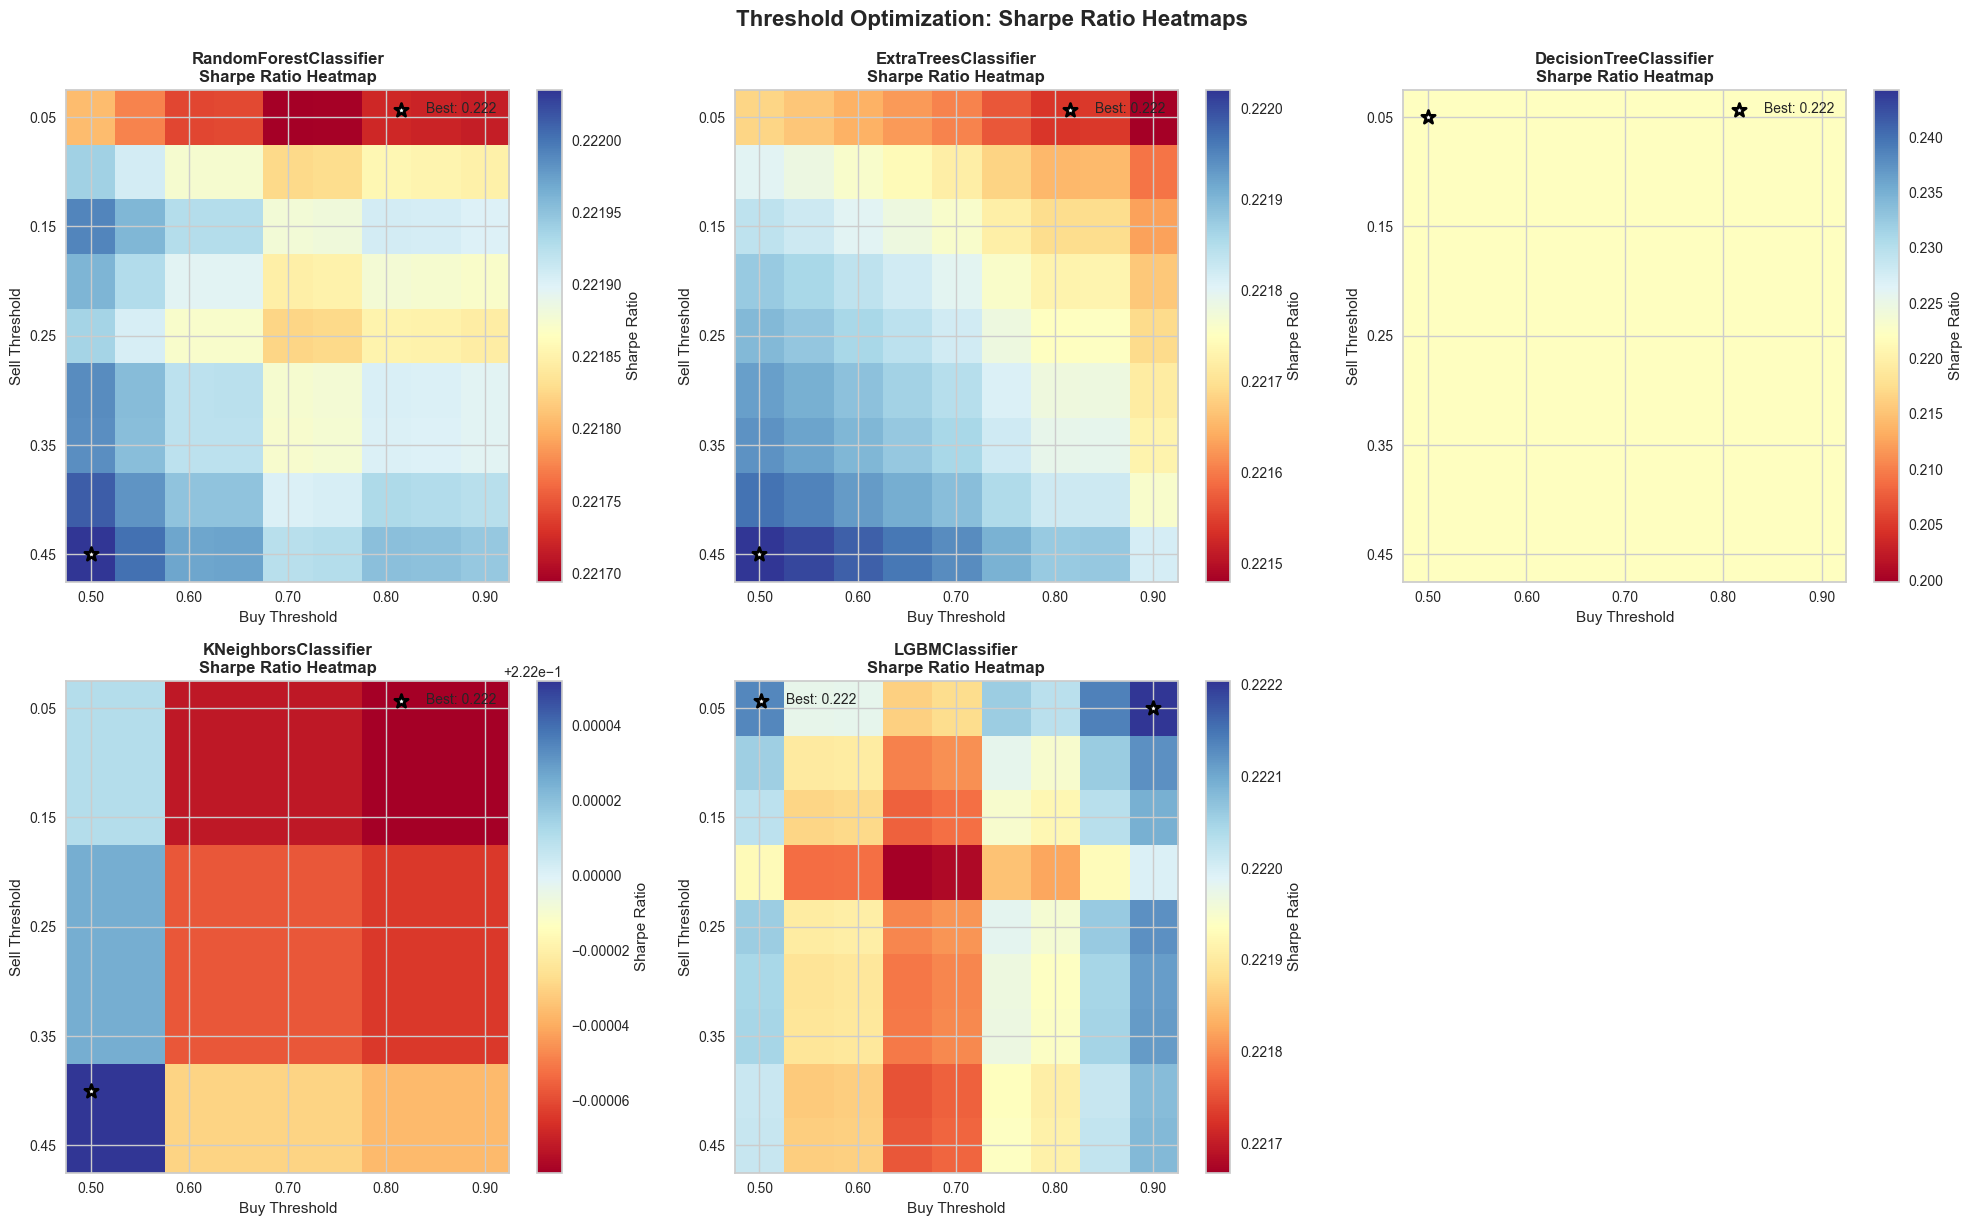

In [12]:
# Visualize threshold optimization results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (model_name, opt_df) in enumerate(threshold_optimization_results.items()):
    if not opt_df.empty:
        ax = axes[i]
        
        # Create a pivot table for heatmap
        pivot_data = opt_df.pivot_table(
            values='sharpe_ratio', 
            index='sell_threshold', 
            columns='buy_threshold', 
            aggfunc='first'
        )
        
        # Create heatmap
        im = ax.imshow(pivot_data.values, cmap='RdYlBu', aspect='auto')
        
        # Set labels
        ax.set_title(f'{model_name}\nSharpe Ratio Heatmap', fontsize=12, fontweight='bold')
        ax.set_xlabel('Buy Threshold')
        ax.set_ylabel('Sell Threshold')
        
        # Set ticks
        buy_ticks = np.arange(0, len(pivot_data.columns), 2)
        sell_ticks = np.arange(0, len(pivot_data.index), 2)
        ax.set_xticks(buy_ticks)
        ax.set_yticks(sell_ticks)
        ax.set_xticklabels([f'{pivot_data.columns[i]:.2f}' for i in buy_ticks])
        ax.set_yticklabels([f'{pivot_data.index[i]:.2f}' for i in sell_ticks])
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Sharpe Ratio')
        
        # Find and mark the best combination
        best_idx = opt_df['sharpe_ratio'].idxmax()
        best_row = opt_df.loc[best_idx]
        
        # Find position in heatmap
        buy_pos = list(pivot_data.columns).index(best_row['buy_threshold'])
        sell_pos = list(pivot_data.index).index(best_row['sell_threshold'])
        
        # Mark best point
        ax.scatter(buy_pos, sell_pos, c='white', s=100, marker='*', 
                  edgecolors='black', linewidth=2, label=f'Best: {best_row["sharpe_ratio"]:.3f}')
        ax.legend()

# Remove empty subplot
if len(threshold_optimization_results) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Threshold Optimization: Sharpe Ratio Heatmaps', fontsize=16, fontweight='bold', y=1.02)
plt.show()


=== Position Sizing Analysis: RandomForestClassifier ===
Using optimal buy threshold: 0.50

--- LINEAR Position Sizing ---
Active Positions: 109,033
Avg Position Size: 0.994
Avg Weighted Return: 0.013056
Total Weighted Return: 1423.5042
Sharpe Ratio: 0.2249
Positive Rate: 0.529

--- EXPONENTIAL Position Sizing ---
Active Positions: 109,033
Avg Position Size: 0.990
Avg Weighted Return: 0.013006
Total Weighted Return: 1418.1179
Sharpe Ratio: 0.2245
Positive Rate: 0.529

--- STEP Position Sizing ---
Active Positions: 109,042
Avg Position Size: 0.996
Avg Weighted Return: 0.013096
Total Weighted Return: 1428.0309
Sharpe Ratio: 0.2252
Positive Rate: 0.529


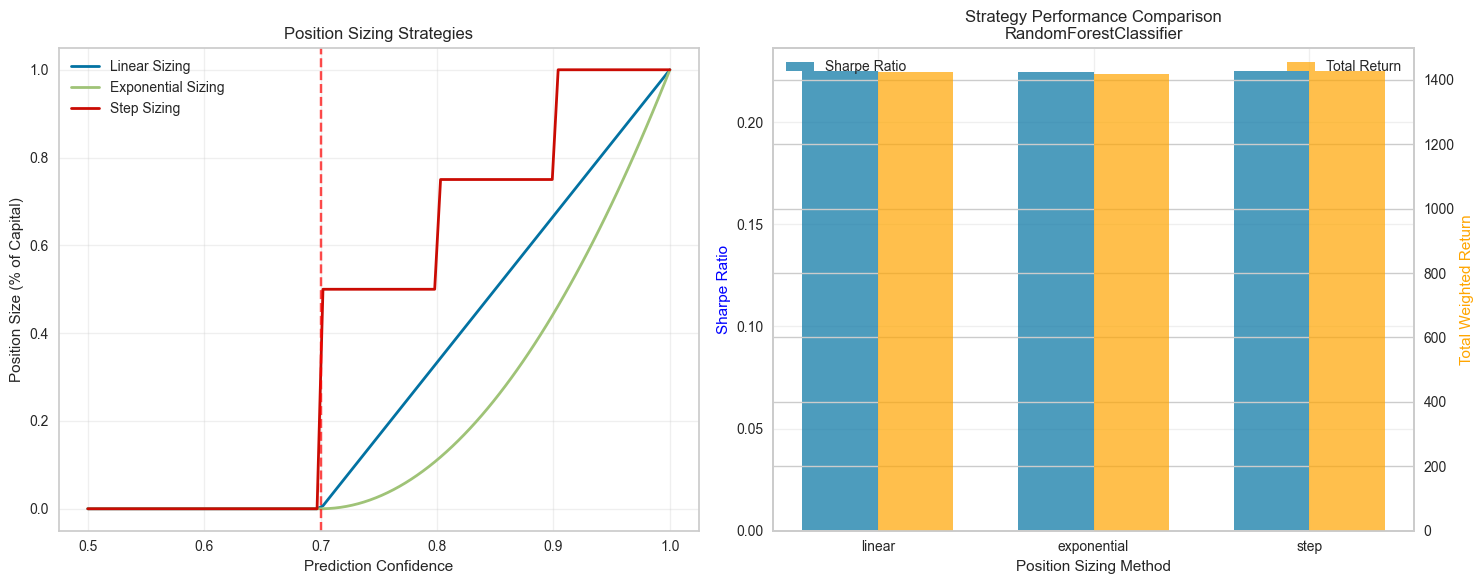

In [13]:
# Implement probability-based position sizing strategy
def calculate_position_size(confidence, buy_threshold=0.7, max_position_pct=1.0, sizing_method='linear'):
    """
    Calculate position size based on prediction confidence
    
    Parameters:
    - confidence: Model prediction probability (0-1)
    - buy_threshold: Minimum confidence required for any position
    - max_position_pct: Maximum position size as percentage of capital
    - sizing_method: 'linear', 'exponential', or 'step'
    """
    
    if confidence < buy_threshold:
        return 0.0
    
    if sizing_method == 'linear':
        # Linear scaling from threshold to 1.0
        normalized_confidence = (confidence - buy_threshold) / (1.0 - buy_threshold)
        position_size = max_position_pct * normalized_confidence
        
    elif sizing_method == 'exponential':
        # Exponential scaling - more conservative
        normalized_confidence = (confidence - buy_threshold) / (1.0 - buy_threshold)
        position_size = max_position_pct * (normalized_confidence ** 2)
        
    elif sizing_method == 'step':
        # Step-based sizing
        if confidence >= 0.9:
            position_size = max_position_pct
        elif confidence >= 0.8:
            position_size = max_position_pct * 0.75
        elif confidence >= buy_threshold:
            position_size = max_position_pct * 0.5
        else:
            position_size = 0.0
    
    return min(position_size, max_position_pct)

# Test different position sizing strategies
sizing_methods = ['linear', 'exponential', 'step']
position_sizing_analysis = {}

for model_name, results in list(prediction_results.items())[:1]:  # Test with first model
    print(f"\n=== Position Sizing Analysis: {model_name} ===")
    
    probabilities = results['probabilities']
    actual_returns = results['actual_returns']
    
    # Get optimal thresholds from previous analysis
    if model_name in threshold_optimization_results:
        opt_df = threshold_optimization_results[model_name]
        best_threshold = opt_df.loc[opt_df['sharpe_ratio'].idxmax(), 'buy_threshold']
    else:
        best_threshold = 0.7  # Default
    
    print(f"Using optimal buy threshold: {best_threshold:.2f}")
    
    analysis_results = {}
    
    for method in sizing_methods:
        print(f"\n--- {method.upper()} Position Sizing ---")
        
        # Calculate position sizes for all predictions
        position_sizes = np.array([
            calculate_position_size(conf, best_threshold, 1.0, method) 
            for conf in probabilities
        ])
        
        # Calculate weighted returns (position size * actual return)
        weighted_returns = position_sizes * actual_returns
        
        # Only consider non-zero positions for metrics
        active_positions = position_sizes > 0
        
        if active_positions.sum() > 0:
            active_weighted_returns = weighted_returns[active_positions]
            active_position_sizes = position_sizes[active_positions]
            active_actual_returns = actual_returns[active_positions]
            
            metrics = {
                'method': method,
                'total_positions': active_positions.sum(),
                'avg_position_size': active_position_sizes.mean(),
                'max_position_size': active_position_sizes.max(),
                'avg_weighted_return': active_weighted_returns.mean(),
                'total_weighted_return': active_weighted_returns.sum(),
                'sharpe_ratio': active_weighted_returns.mean() / active_weighted_returns.std() if active_weighted_returns.std() > 0 else 0,
                'positive_rate': (active_weighted_returns > 0).mean(),
                'max_drawdown': np.min(np.cumsum(active_weighted_returns) - np.maximum.accumulate(np.cumsum(active_weighted_returns))),
                'total_volume': active_position_sizes.sum()
            }
            
            analysis_results[method] = metrics
            
            print(f"Active Positions: {metrics['total_positions']:,}")
            print(f"Avg Position Size: {metrics['avg_position_size']:.3f}")
            print(f"Avg Weighted Return: {metrics['avg_weighted_return']:.6f}")
            print(f"Total Weighted Return: {metrics['total_weighted_return']:.4f}")
            print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
            print(f"Positive Rate: {metrics['positive_rate']:.3f}")
    
    position_sizing_analysis[model_name] = analysis_results

# Visualize position sizing strategies
test_confidences = np.linspace(0.5, 1.0, 100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot position sizing functions
for method in sizing_methods:
    position_sizes = [calculate_position_size(conf, 0.7, 1.0, method) for conf in test_confidences]
    ax1.plot(test_confidences, position_sizes, label=f'{method.title()} Sizing', linewidth=2)

ax1.set_xlabel('Prediction Confidence')
ax1.set_ylabel('Position Size (% of Capital)')
ax1.set_title('Position Sizing Strategies')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axvline(x=0.7, color='red', linestyle='--', alpha=0.7, label='Threshold')

# Compare strategy performance
if position_sizing_analysis:
    model_name = list(position_sizing_analysis.keys())[0]
    strategies = position_sizing_analysis[model_name]
    
    methods = list(strategies.keys())
    sharpe_ratios = [strategies[method]['sharpe_ratio'] for method in methods]
    total_returns = [strategies[method]['total_weighted_return'] for method in methods]
    
    x = np.arange(len(methods))
    width = 0.35
    
    ax2.bar(x - width/2, sharpe_ratios, width, label='Sharpe Ratio', alpha=0.7)
    ax2_twin = ax2.twinx()
    ax2_twin.bar(x + width/2, total_returns, width, label='Total Return', alpha=0.7, color='orange')
    
    ax2.set_xlabel('Position Sizing Method')
    ax2.set_ylabel('Sharpe Ratio', color='blue')
    ax2_twin.set_ylabel('Total Weighted Return', color='orange')
    ax2.set_title(f'Strategy Performance Comparison\n{model_name}')
    ax2.set_xticks(x)
    ax2.set_xticklabels(methods)
    ax2.grid(True, alpha=0.3)
    
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
# Conduct comprehensive confidence-based backtesting
def confidence_based_backtest(probabilities, prices, actual_returns, timestamps, 
                            buy_threshold=0.7, sell_threshold=0.3, 
                            position_sizing_method='linear', initial_capital=10000,
                            fee_pct=0.0075, stop_loss_pct=0.05):
    """
    Comprehensive backtesting with confidence-based trading
    """
    
    # Convert to DataFrame for easier handling
    df_bt = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'close': prices,
        'probability': probabilities,
        'actual_return': actual_returns
    }).sort_values('timestamp').reset_index(drop=True)
    
    # Initialize variables
    position = 0
    cash = initial_capital
    trade_log = []
    portfolio_values = []
    in_trade = False
    entry_price = 0
    entry_time = None
    entry_confidence = 0
    total_invested = 0
    entry_fees = 0
    
    for i in range(len(df_bt)):
        row = df_bt.iloc[i]
        confidence = row['probability']
        current_price = row['close']
        date = row['timestamp']
        
        # Calculate dynamic position size based on confidence
        position_size_pct = calculate_position_size(confidence, buy_threshold, 1.0, position_sizing_method)
        
        # Entry Logic: High confidence buy signal
        if confidence >= buy_threshold and not in_trade and position_size_pct > 0:
            # Calculate investment amount based on confidence
            available_for_investment = cash * position_size_pct
            gross_position_value = available_for_investment / (1 + fee_pct)
            position = gross_position_value / current_price
            entry_fees = gross_position_value * fee_pct
            total_invested = gross_position_value + entry_fees
            entry_price = current_price
            entry_time = date
            entry_confidence = confidence
            cash -= total_invested
            in_trade = True
        
        # Exit Logic: Low confidence sell signal OR Stop-loss OR Fee-aware exit
        elif in_trade:
            current_value = position * current_price
            price_change = (current_value - total_invested) / total_invested
            
            # Check conditions
            stop_loss_hit = price_change <= -stop_loss_pct
            low_confidence_exit = confidence <= sell_threshold
            fee_checker = (current_price - entry_price) / entry_price > fee_pct * 2
            
            # Exit decision
            should_exit = stop_loss_hit or (low_confidence_exit and fee_checker)
            
            if should_exit:
                # Calculate exit with fees
                gross_exit_value = position * current_price
                exit_fees = gross_exit_value * fee_pct
                exit_cash = gross_exit_value - exit_fees
                
                # Calculate PnL
                pnl = exit_cash - total_invested
                return_pct = pnl / total_invested * 100
                
                # Determine exit type
                if stop_loss_hit:
                    exit_type = 'Stop-Loss'
                elif low_confidence_exit and fee_checker:
                    exit_type = 'Low-Confidence + Fee-Aware'
                elif low_confidence_exit:
                    exit_type = 'Low-Confidence (Fee-Blocked)'
                else:
                    exit_type = 'Other'
                
                # Log the trade
                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Entry Confidence': round(entry_confidence, 3),
                    'Exit Time': date,
                    'Exit Price': round(current_price, 2),
                    'Exit Confidence': round(confidence, 3),
                    'Position Size (%)': round(position_size_pct * 100, 1),
                    'Investment ($)': round(total_invested, 2),
                    'Exit Value ($)': round(exit_cash, 2),
                    'Entry Fees ($)': round(entry_fees, 2),
                    'Exit Fees ($)': round(exit_fees, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Hold Duration (min)': int((date - entry_time).total_seconds() / 60),
                    'Exit Type': exit_type
                })
                
                cash += exit_cash
                position = 0
                in_trade = False
                total_invested = 0

        # Record portfolio value
        if in_trade:
            current_gross_value = position * current_price
            estimated_exit_fees = current_gross_value * fee_pct
            portfolio_value = cash + current_gross_value - estimated_exit_fees
        else:
            portfolio_value = cash
            
        portfolio_values.append({
            'timestamp': date, 
            'portfolio': portfolio_value,
            'in_trade': in_trade,
            'confidence': confidence
        })
    
    # Handle remaining open position
    if in_trade:
        final_price = df_bt['close'].iloc[-1]
        gross_exit_value = position * final_price
        exit_fees = gross_exit_value * fee_pct
        exit_cash = gross_exit_value - exit_fees
        pnl = exit_cash - total_invested
        return_pct = pnl / total_invested * 100
        
        trade_log.append({
            'Entry Time': entry_time,
            'Entry Price': round(entry_price, 2),
            'Entry Confidence': round(entry_confidence, 3),
            'Exit Time': df_bt['timestamp'].iloc[-1],
            'Exit Price': round(final_price, 2),
            'Exit Confidence': round(df_bt['probability'].iloc[-1], 3),
            'Position Size (%)': round(position_size_pct * 100, 1),
            'Investment ($)': round(total_invested, 2),
            'Exit Value ($)': round(exit_cash, 2),
            'Entry Fees ($)': round(entry_fees, 2),
            'Exit Fees ($)': round(exit_fees, 2),
            'PnL ($)': round(pnl, 2),
            'Return (%)': round(return_pct, 2),
            'Hold Duration (min)': int((df_bt['timestamp'].iloc[-1] - entry_time).total_seconds() / 60),
            'Exit Type': 'End of Period'
        })
        cash += exit_cash
    
    return {
        'portfolio_history': pd.DataFrame(portfolio_values),
        'trade_log': pd.DataFrame(trade_log),
        'final_cash': cash,
        'initial_capital': initial_capital
    }

print("✅ Confidence-based backtesting function implemented")

✅ Confidence-based backtesting function implemented


In [17]:
# Run confidence-based backtesting for all models
confidence_backtest_results = {}

# Get unique timestamps and prices from original dataset
timestamps = pd.to_datetime(df['Timestamp'])
prices = df['Close'].values

for model_name, results in prediction_results.items():
    print(f"\n{'='*60}")
    print(f"CONFIDENCE-BASED BACKTESTING: {model_name}")
    print(f"{'='*60}")
    
    # Get optimal thresholds from previous optimization
    if model_name in threshold_optimization_results:
        opt_df = threshold_optimization_results[model_name]
        best_row = opt_df.loc[opt_df['sharpe_ratio'].idxmax()]
        buy_threshold = best_row['buy_threshold']
        sell_threshold = best_row['sell_threshold']
    else:
        buy_threshold, sell_threshold = 0.7, 0.3  # Defaults
    
    print(f"Using optimized thresholds: Buy≥{buy_threshold:.2f}, Sell≤{sell_threshold:.2f}")
    
    # Run backtesting with different position sizing methods
    for sizing_method in ['linear', 'exponential', 'step']:
        print(f"\n--- {sizing_method.upper()} Position Sizing ---")
        
        backtest_result = confidence_based_backtest(
            probabilities=results['probabilities'],
            prices=prices,
            actual_returns=results['actual_returns'],
            timestamps=timestamps,
            buy_threshold=buy_threshold,
            sell_threshold=sell_threshold,
            position_sizing_method=sizing_method,
            initial_capital=10000
        )
        
        # Calculate performance metrics
        final_value = backtest_result['final_cash']
        initial_capital = backtest_result['initial_capital']
        total_return = ((final_value - initial_capital) / initial_capital) * 100
        
        trade_log = backtest_result['trade_log']
        portfolio_history = backtest_result['portfolio_history']
        
        # Additional metrics
        if len(trade_log) > 0:
            win_rate = (trade_log['PnL ($)'] > 0).mean() * 100
            avg_trade_return = trade_log['Return (%)'].mean()
            avg_hold_duration = trade_log['Hold Duration (min)'].mean()
            total_fees = trade_log['Entry Fees ($)'].sum() + trade_log['Exit Fees ($)'].sum()
            avg_confidence_entry = trade_log['Entry Confidence'].mean()
            avg_confidence_exit = trade_log['Exit Confidence'].mean()
            avg_position_size = trade_log['Position Size (%)'].mean()
            
            # Portfolio metrics
            portfolio_returns = portfolio_history['portfolio'].pct_change().dropna()
            if len(portfolio_returns) > 0 and portfolio_returns.std() > 0:
                sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(365 * 24 * 60)
            else:
                sharpe_ratio = 0
                
            # Drawdown
            peak = portfolio_history['portfolio'].cummax()
            drawdown = (portfolio_history['portfolio'] - peak) / peak
            max_drawdown = abs(drawdown.min()) * 100
            
            # Exit type analysis
            exit_types = trade_log['Exit Type'].value_counts()
            
        else:
            win_rate = avg_trade_return = avg_hold_duration = 0
            total_fees = avg_confidence_entry = avg_confidence_exit = 0
            avg_position_size = sharpe_ratio = max_drawdown = 0
            exit_types = pd.Series()
        
        # Store results
        strategy_key = f"{model_name}_{sizing_method}"
        confidence_backtest_results[strategy_key] = {
            'model': model_name,
            'sizing_method': sizing_method,
            'buy_threshold': buy_threshold,
            'sell_threshold': sell_threshold,
            'final_value': final_value,
            'total_return_%': total_return,
            'trade_count': len(trade_log),
            'win_rate_%': win_rate,
            'avg_trade_return_%': avg_trade_return,
            'avg_hold_duration_min': avg_hold_duration,
            'avg_position_size_%': avg_position_size,
            'avg_confidence_entry': avg_confidence_entry,
            'avg_confidence_exit': avg_confidence_exit,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_%': max_drawdown,
            'total_fees_$': total_fees,
            'trade_log': trade_log,
            'portfolio_history': portfolio_history,
            'exit_types': exit_types
        }
        
        # Print performance summary
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Trade Count: {len(trade_log)}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Avg Trade Return: {avg_trade_return:.2f}%")
        print(f"Avg Hold Duration: {avg_hold_duration:.1f} minutes")
        print(f"Avg Position Size: {avg_position_size:.1f}%")
        print(f"Avg Entry Confidence: {avg_confidence_entry:.3f}")
        print(f"Avg Exit Confidence: {avg_confidence_exit:.3f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Total Fees: ${total_fees:.2f}")
        
        if len(exit_types) > 0:
            print("Exit Type Distribution:")
            for exit_type, count in exit_types.items():
                print(f"  {exit_type}: {count} ({count/len(trade_log)*100:.1f}%)")

print(f"\n✅ Confidence-based backtesting completed for {len(confidence_backtest_results)} strategies")


CONFIDENCE-BASED BACKTESTING: RandomForestClassifier
Using optimized thresholds: Buy≥0.50, Sell≤0.45

--- LINEAR Position Sizing ---
Final Portfolio Value: $719.17
Total Return: -92.81%
Trade Count: 220
Win Rate: 69.5%
Avg Trade Return: -1.16%
Avg Hold Duration: 2085.7 minutes
Avg Position Size: 4.1%
Avg Entry Confidence: 0.999
Avg Exit Confidence: 0.043
Sharpe Ratio: -6.363
Max Drawdown: 92.93%
Total Fees: $11642.95
Exit Type Distribution:
  Low-Confidence + Fee-Aware: 172 (78.2%)
  Stop-Loss: 47 (21.4%)
  End of Period: 1 (0.5%)

--- EXPONENTIAL Position Sizing ---
Final Portfolio Value: $723.09
Total Return: -92.77%
Trade Count: 220
Win Rate: 69.5%
Avg Trade Return: -1.16%
Avg Hold Duration: 2085.7 minutes
Avg Position Size: 4.1%
Avg Entry Confidence: 0.999
Avg Exit Confidence: 0.043
Sharpe Ratio: -6.357
Max Drawdown: 92.89%
Total Fees: $11614.09
Exit Type Distribution:
  Low-Confidence + Fee-Aware: 172 (78.2%)
  Stop-Loss: 47 (21.4%)
  End of Period: 1 (0.5%)

--- STEP Position Si

In [18]:
# Create comprehensive performance comparison
performance_comparison = []

for strategy_key, results in confidence_backtest_results.items():
    performance_comparison.append({
        'Strategy': strategy_key,
        'Model': results['model'],
        'Sizing': results['sizing_method'],
        'Buy Threshold': results['buy_threshold'],
        'Sell Threshold': results['sell_threshold'],
        'Final Value ($)': results['final_value'],
        'Total Return (%)': results['total_return_%'],
        'Trade Count': results['trade_count'],
        'Win Rate (%)': results['win_rate_%'],
        'Avg Trade Return (%)': results['avg_trade_return_%'],
        'Avg Hold Duration (min)': results['avg_hold_duration_min'],
        'Avg Position Size (%)': results['avg_position_size_%'],
        'Avg Entry Confidence': results['avg_confidence_entry'],
        'Sharpe Ratio': results['sharpe_ratio'],
        'Max Drawdown (%)': results['max_drawdown_%'],
        'Total Fees ($)': results['total_fees_$']
    })

comparison_df = pd.DataFrame(performance_comparison)
print("\n" + "="*100)
print("CONFIDENCE-BASED STRATEGY PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.round(3))

# Find best performing strategies
print("\n" + "="*60)
print("TOP PERFORMING STRATEGIES")
print("="*60)

# Best by total return
best_return = comparison_df.loc[comparison_df['Total Return (%)'].idxmax()]
print(f"\n🏆 BEST TOTAL RETURN:")
print(f"Strategy: {best_return['Strategy']}")
print(f"Return: {best_return['Total Return (%)']:.2f}%")
print(f"Sharpe: {best_return['Sharpe Ratio']:.3f}")
print(f"Trades: {best_return['Trade Count']:.0f}")
print(f"Win Rate: {best_return['Win Rate (%)']:.1f}%")

# Best by Sharpe ratio
if comparison_df['Sharpe Ratio'].max() > 0:
    best_sharpe = comparison_df.loc[comparison_df['Sharpe Ratio'].idxmax()]
    print(f"\n📈 BEST SHARPE RATIO:")
    print(f"Strategy: {best_sharpe['Strategy']}")
    print(f"Sharpe: {best_sharpe['Sharpe Ratio']:.3f}")
    print(f"Return: {best_sharpe['Total Return (%)']:.2f}%")
    print(f"Trades: {best_sharpe['Trade Count']:.0f}")
    print(f"Win Rate: {best_sharpe['Win Rate (%)']:.1f}%")

# Best win rate
if comparison_df['Win Rate (%)'].max() > 0:
    best_win_rate = comparison_df.loc[comparison_df['Win Rate (%)'].idxmax()]
    print(f"\n🎯 BEST WIN RATE:")
    print(f"Strategy: {best_win_rate['Strategy']}")
    print(f"Win Rate: {best_win_rate['Win Rate (%)']:.1f}%")
    print(f"Return: {best_win_rate['Total Return (%)']:.2f}%")
    print(f"Trades: {best_win_rate['Trade Count']:.0f}")
    print(f"Avg Trade Return: {best_win_rate['Avg Trade Return (%)']:.2f}%")


CONFIDENCE-BASED STRATEGY PERFORMANCE COMPARISON
                              Strategy                   Model       Sizing  \
0        RandomForestClassifier_linear  RandomForestClassifier       linear   
1   RandomForestClassifier_exponential  RandomForestClassifier  exponential   
2          RandomForestClassifier_step  RandomForestClassifier         step   
3          ExtraTreesClassifier_linear    ExtraTreesClassifier       linear   
4     ExtraTreesClassifier_exponential    ExtraTreesClassifier  exponential   
5            ExtraTreesClassifier_step    ExtraTreesClassifier         step   
6        DecisionTreeClassifier_linear  DecisionTreeClassifier       linear   
7   DecisionTreeClassifier_exponential  DecisionTreeClassifier  exponential   
8          DecisionTreeClassifier_step  DecisionTreeClassifier         step   
9          KNeighborsClassifier_linear    KNeighborsClassifier       linear   
10    KNeighborsClassifier_exponential    KNeighborsClassifier  exponential   
11